In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn import metrics
from collections import defaultdict
import matplotlib.pyplot as plt
import glob


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

## Import libraries
import re
import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords' )

import string
from string import punctuation
import matplotlib.pyplot as plt

### Getting Familiar with the datasets

In [2]:
# read csv file

import json

file1 = open('tweets_#gohawks.txt', 'r')
lines = file1.readlines()

In [3]:
for line in lines:
    json_object = json.loads(line)
    if json_object['url']== 'http://twitter.com/Geras_Suo/status/549575600210718721':
        break
json_object

{'firstpost_date': 1419864008,
 'title': 'twelfth dogs are ready! #gohawks #dogslife http://t.co/gd3v6vQps5',
 'url': 'http://twitter.com/Geras_Suo/status/549575600210718721',
 'tweet': {'contributors': None,
  'truncated': False,
  'text': 'twelfth dogs are ready! #gohawks #dogslife http://t.co/gd3v6vQps5',
  'in_reply_to_status_id': None,
  'id': 549575600210718721,
  'favorite_count': 0,
  'source': '<a href="http://www.apple.com" rel="nofollow">iOS</a>',
  'retweeted': False,
  'coordinates': None,
  'timestamp_ms': '1419864008368',
  'entities': {'symbols': [],
   'media': [{'expanded_url': 'http://twitter.com/Geras_Suo/status/549575600210718721/photo/1',
     'sizes': {'large': {'h': 640, 'resize': 'fit', 'w': 480},
      'small': {'h': 453, 'resize': 'fit', 'w': 340},
      'medium': {'h': 640, 'resize': 'fit', 'w': 480},
      'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
     'url': 'http://t.co/gd3v6vQps5',
     'media_url_https': 'https://pbs.twimg.com/media/B6B8GLiIYAAC

In [4]:
json_object['tweet']['user'].keys()

dict_keys(['follow_request_sent', 'profile_use_background_image', 'geo_enabled', 'description', 'verified', 'profile_image_url_https', 'profile_sidebar_fill_color', 'is_translator', 'id', 'profile_text_color', 'followers_count', 'profile_sidebar_border_color', 'id_str', 'default_profile_image', 'location', 'utc_offset', 'statuses_count', 'profile_background_color', 'friends_count', 'profile_link_color', 'profile_image_url', 'notifications', 'profile_background_image_url_https', 'profile_background_image_url', 'name', 'lang', 'profile_background_tile', 'favourites_count', 'screen_name', 'url', 'created_at', 'contributors_enabled', 'time_zone', 'protected', 'default_profile', 'following', 'listed_count'])

In [5]:
df = { 'tweet': [],
         'retweets': [],
         'time': [],
            'timestamp': [],
         'followers': []}

In [6]:
import pytz
import datetime

pst_tz = pytz.timezone('America/Los_Angeles')



In [7]:

file1 = open('tweets_#gohawks.txt', 'r')
lines = file1.readlines()

for line in lines:
    json_object = json.loads(line)
    df['tweet'].append(json_object['title'])
    df['retweets'].append(json_object['metrics']['citations']['total'])
    df['time'].append(json_object['citation_date'])
    df['timestamp'].append(datetime.datetime.fromtimestamp(json_object['citation_date'], pst_tz))
    df['followers'].append(json_object['author']['followers'])

In [8]:
df = pd.DataFrame(df)

In [9]:
df.sort_values(by='timestamp')

,tweet,retweets,time,timestamp,followers
205,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,1,1421222681,2015-01-14 00:04:41-08:00,570.0
206,Enganchado a @ATLHawks \nQué temporadón! Hoy t...,2,1421222699,2015-01-14 00:04:59-08:00,85.0
203,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,3,1421222750,2015-01-14 00:05:50-08:00,120.0
207,At http://t.co/Vd0RWOeAed -- #beatthepackers #...,1,1421222961,2015-01-14 00:09:21-08:00,1175.0
208,@Trapstar_DJ the more the merrier! #GoHawks,1,1421223140,2015-01-14 00:12:20-08:00,419.0
...,...,...,...,...,...
169117,How long to you think that it will be until we...,1,1423290285,2015-02-06 22:24:45-08:00,120.0
169118,"#Seahawks all day, everyday!!! #beastmode #LOB...",3,1423291665,2015-02-06 22:47:45-08:00,47.0
169119,Interview With the Seattle Seahawks Superbowl ...,1,1423295642,2015-02-06 23:54:02-08:00,1496.0
169120,If you love Russell Wilson and want to know mo...,1,1423295796,2015-02-06 23:56:36-08:00,120.0


## Question 27 & Question 28

In [10]:
hashtags = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

In [11]:
def tweetstats(hashtag):

    file_name = 'tweets_#' + hashtag + '.txt'
    retweets   = []
    timestamp   = []
    followers  = []

    lines = open(file_name, 'r', encoding='utf8')

    for i, line in enumerate(lines):
        tweet = json.loads(line)
        timestamp.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz))
        retweets.append(tweet['metrics']['citations']['total'])
        followers.append(tweet['author']['followers'])
        

    df = pd.DataFrame(timestamp, columns=['time']).set_index('time')
    tweets_by_hour = df.groupby(pd.Grouper(freq='60Min'))
    count_by_hour = [len(val) for key, val in tweets_by_hour]
    total_hours = len(tweets_by_hour)

    print("Avg number of tweets per hour", len(timestamp) / total_hours)
    print("Avg number of retweets - ", np.mean(retweets))
    print("Avg number of followers - ", np.mean(followers))

    if hashtag in ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']:         
        plt.figure(figsize=(20,10))
        plt.grid(zorder=0)
        plt.bar(range(len(tweets_by_hour.groups.keys())), count_by_hour,width=1,color = 'r',align='center')
        plt.xlabel('Hour',fontsize=16)
        plt.ylabel('Number of tweets',fontsize=16)
        plt.title('Number of tweets per hour' + ' ' + hashtag,fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()


 Printing for  gohawks
Avg number of tweets per hour 292.09326424870466
Avg number of retweets -  2.0132093991319877
Avg number of followers -  2217.9237355281984


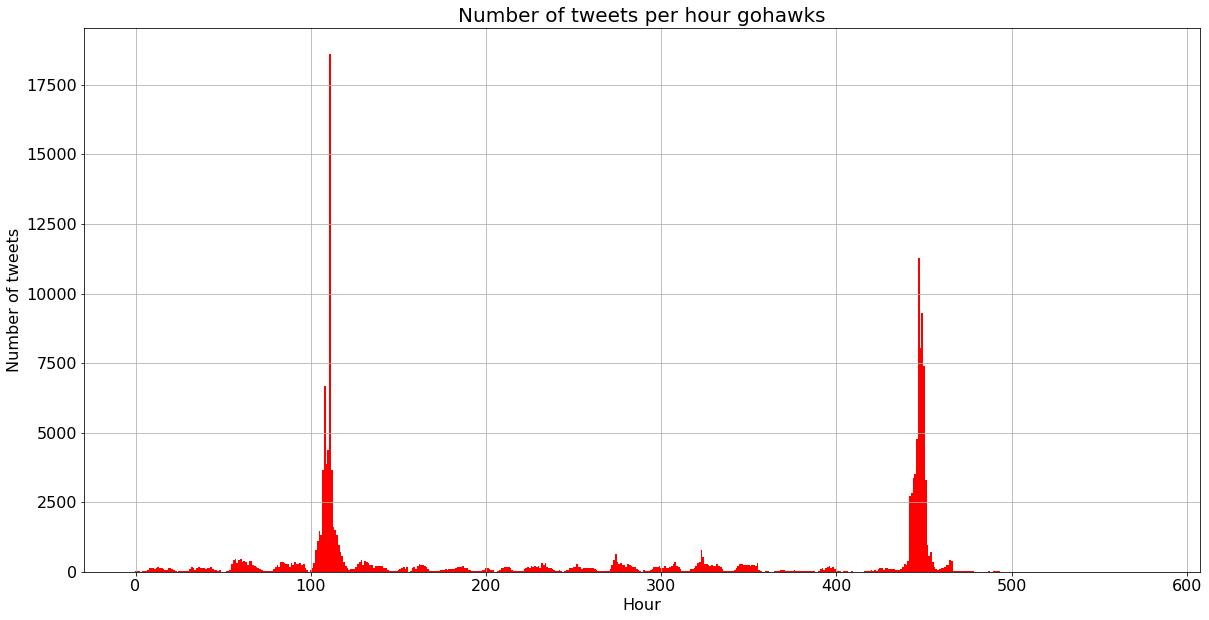


 Printing for  gopatriots
Avg number of tweets per hour 40.888695652173915
Avg number of retweets -  1.4081919101697078
Avg number of followers -  1427.2526051635405


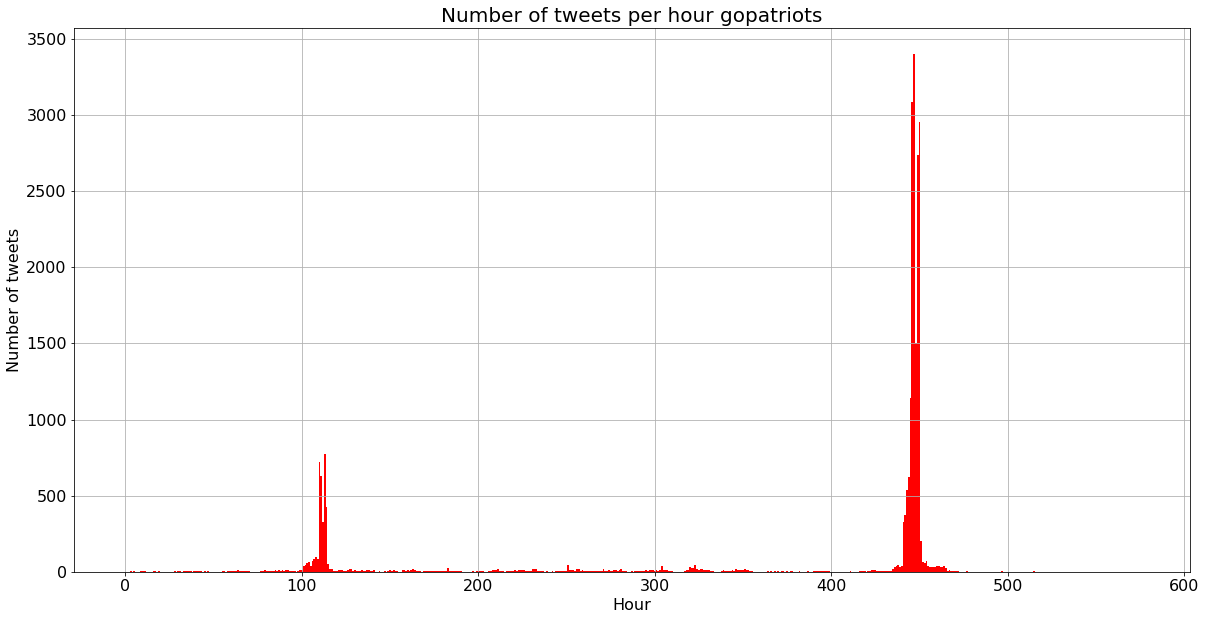


 Printing for  nfl
Avg number of tweets per hour 396.97103918228277
Avg number of retweets -  1.5344602655543254
Avg number of followers -  4662.37544523693


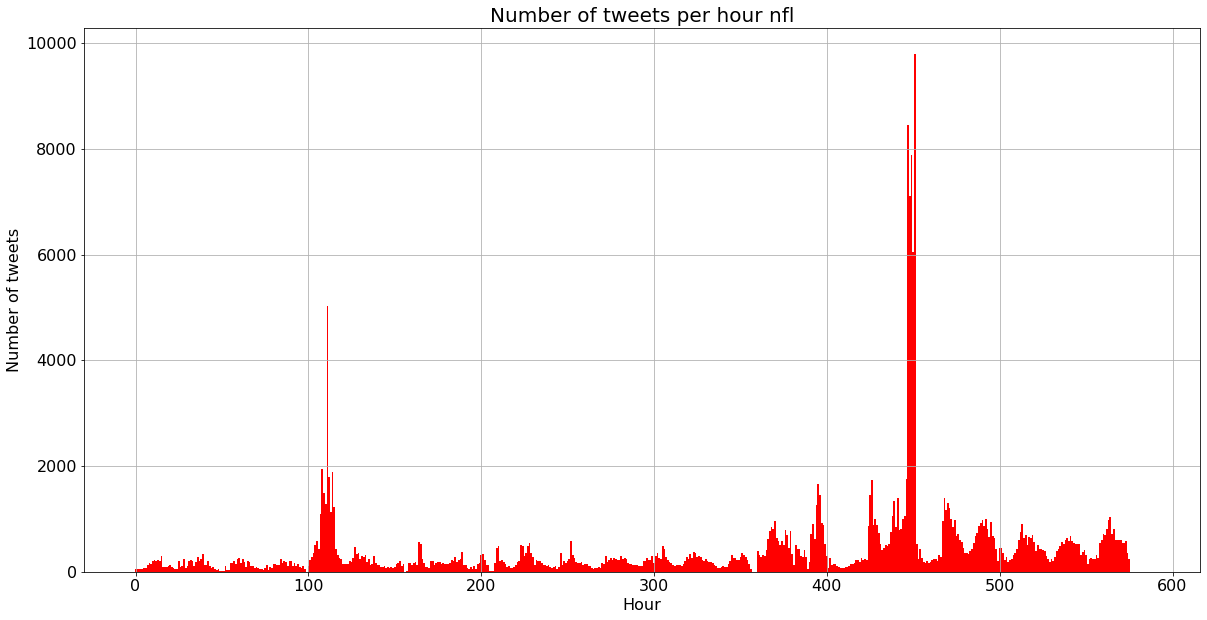


 Printing for  patriots
Avg number of tweets per hour 750.6320272572402
Avg number of retweets -  1.7852871288476946
Avg number of followers -  3280.4635616550277


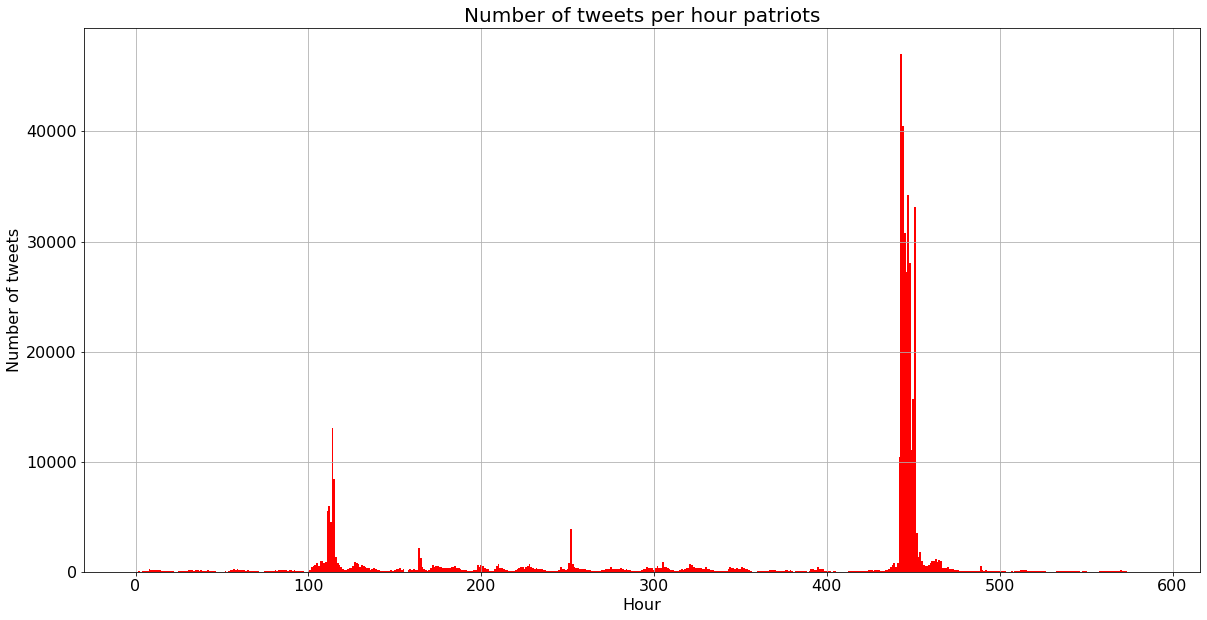


 Printing for  sb49
Avg number of tweets per hour 1275.5557461406518
Avg number of retweets -  2.52713444111402
Avg number of followers -  10374.160292019487


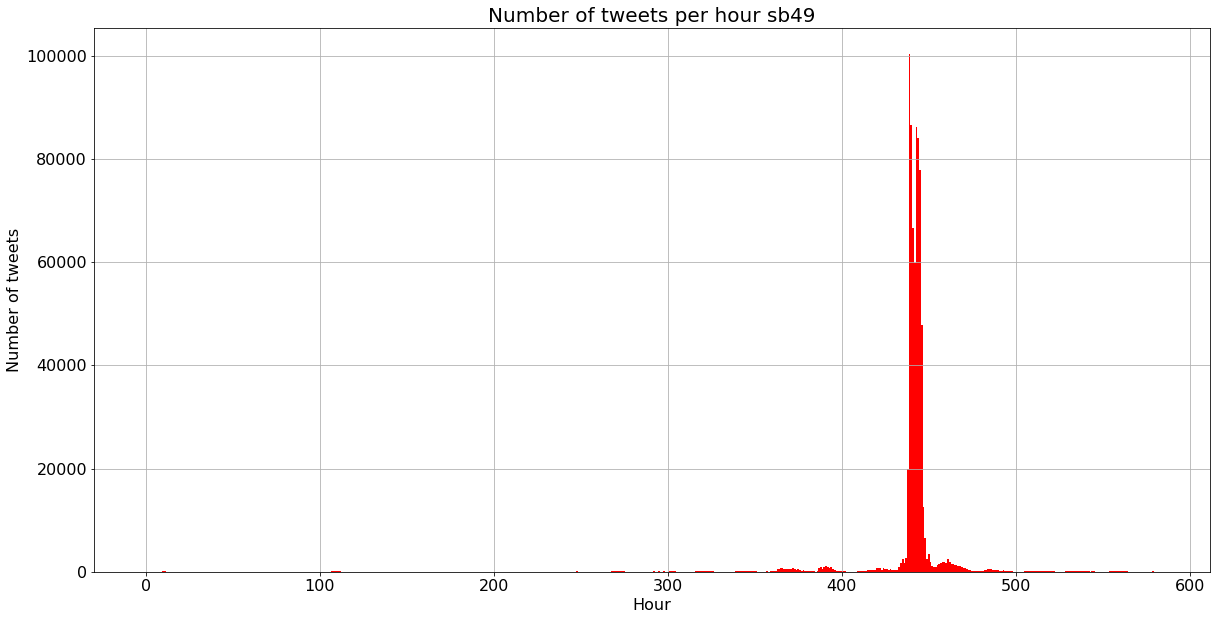


 Printing for  superbowl
Avg number of tweets per hour 2067.824531516184
Avg number of retweets -  2.3911895819207736
Avg number of followers -  8814.96799424623


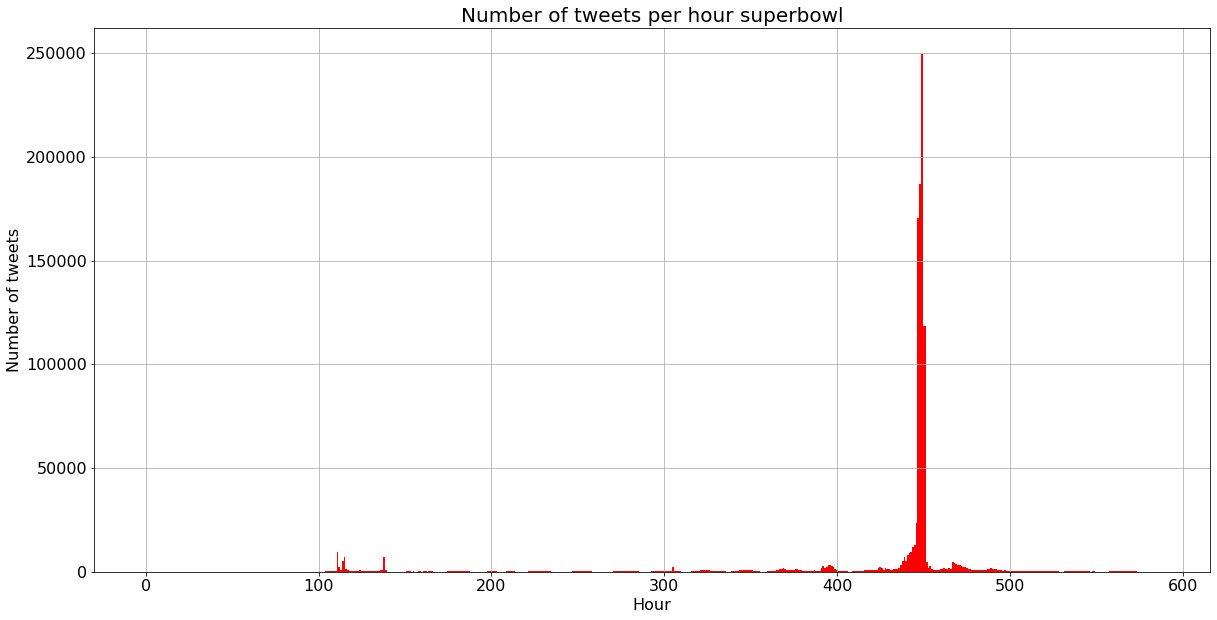

In [12]:
for tag in hashtags:
    print("\n Printing for ", tag)
    tweetstats(tag)

## Question 29

In [13]:
############# Import relevant packages ###############
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import random
import pandas as pd
import numpy as np
import re, json, datetime, pytz
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from collections import Counter
import nltk
############# Import relevant packages ###############


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [14]:
from happytransformer import HappyTextClassification
happy_tc = HappyTextClassification(model_type="DISTILBERT", 
                                       model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

03/15/2022 20:30:25 - INFO - happytransformer.happy_transformer -   Using model: cuda


In [15]:
from transformers import pipeline
pipe = pipeline(task='text2text-generation', model='facebook/m2m100_418M')

In [16]:
def transformer_sentiment(tweet):
    
    result = happy_tc.classify_text(tweet)
    if result.label == 'NEGATIVE':
        return -1, -result.score
    else:
        return 1, result.score
    

In [17]:
def translate_and_transformer_sentiment(tweet):
    
    tweet = pipe(tweet, forced_bos_token_id=pipe.tokenizer.get_lang_id(lang='en'))
    tweet = tweet[0]['generated_text']
    result = happy_tc.classify_text(tweet)
    if result.label == 'NEGATIVE':
        return -1, -result.score
    else:
        return 1, result.score

In [18]:
def full_clean(tweets):
    from sklearn.feature_extraction import text
    stop_words = text.ENGLISH_STOP_WORDS
    corpus = []
    for tweet in tweets:
        clean_tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", tweet).lower().split()
        text = [word for word in clean_tweet if not word in stop_words]
        text = ' '.join(text)
        corpus.append(text)
    return corpus

In [19]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", tweet).split())

In [20]:
def get_player(text, player=['tom', 'brady']):
    with open(text+'.txt', 'r',encoding="utf8") as f:
        retweet_count, fav_count, followers, place, title, time = [],[],[],[],[],[]
        sentiment_polarity, sentiment_score = [], []
        pst_tz = pytz.timezone('US/Pacific') 
        for line in f:
            tweet = json.loads(line)
            tweet_text = tweet['title']
            tweet_text = tweet_text.lower().split()
            for word in player: 
                if word in tweet_text:
                    title.append(tweet['title'])
                    retweet_count.append(tweet['metrics']['citations']['total']) 
                    fav_count.append(tweet['tweet']['favorite_count'])
                    followers.append(tweet['author']['followers'])
                    time.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz))
                    place.append(tweet['tweet']['user']['location'])
                    cleaned_tweet = clean_tweet(tweet['title'])
                    if not tweet['tweet']['lang'] == 'en':
                        senti_polarity, senti_score = translate_and_transformer_sentiment(cleaned_tweet)
                        sentiment_polarity.append(senti_polarity)
                        sentiment_score.append(senti_score)
                    else:
                        senti_polarity, senti_score = transformer_sentiment(cleaned_tweet)
                        sentiment_polarity.append(senti_polarity)
                        sentiment_score.append(senti_score)
                    break
    d = {'title':title, 'retweet_count':retweet_count, 'favourite_count': fav_count, 'followers':followers,
         'time':time,'place':place, 'sentiment_polarity':sentiment_polarity, 'sentiment_score':sentiment_score}
    df = pd.DataFrame(d)
    return df   
################ Get relevant data #########################

In [24]:
def get_player_en(text, player=['tom', 'brady']):
    with open(text+'.txt', 'r',encoding="utf8") as f:
        retweet_count, fav_count, followers, place, title, time = [],[],[],[],[],[]
        sentiment_polarity, sentiment_score = [], []
        pst_tz = pytz.timezone('US/Pacific') 
        for line in f:
            tweet = json.loads(line)
            tweet_text = tweet['title']
            tweet_text = tweet_text.lower().split()
            if tweet['tweet']['lang'] == 'en':
                for word in player: 
                    if word in tweet_text:
                        title.append(tweet['title'])
                        retweet_count.append(tweet['metrics']['citations']['total']) 
                        fav_count.append(tweet['tweet']['favorite_count'])
                        followers.append(tweet['author']['followers'])
                        time.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz))
                        place.append(tweet['tweet']['user']['location'])
                        cleaned_tweet = clean_tweet(tweet['title'])
                        senti_polarity, senti_score = transformer_sentiment(cleaned_tweet)
                        sentiment_polarity.append(senti_polarity)
                        sentiment_score.append(senti_score)
                        break
    d = {'title':title, 'retweet_count':retweet_count, 'favourite_count': fav_count, 'followers':followers,
         'time':time,'place':place, 'sentiment_polarity':sentiment_polarity, 'sentiment_score':sentiment_score}
    df = pd.DataFrame(d)
    return df

In [21]:
df_brady_gopatriots = get_player('tweets_#gopatriots')

/home/shivam/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [22]:
df_brady_gohawks = get_player('tweets_#gohawks')

In [25]:
df_brady_nfl = get_player_en('tweets_#nfl')

In [27]:
df_brady_superbowl = get_player_en('tweets_#superbowl')

/home/shivam/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [29]:
df_brady = df_brady_gopatriots.append(df_brady_gohawks).append(df_brady_nfl).append(df_brady_superbowl)

## Senitment Analysis of Tom Brady 

### Plot for each hours during all time

Text(0.5, 1.0, "Tom Brady's Sentiments")

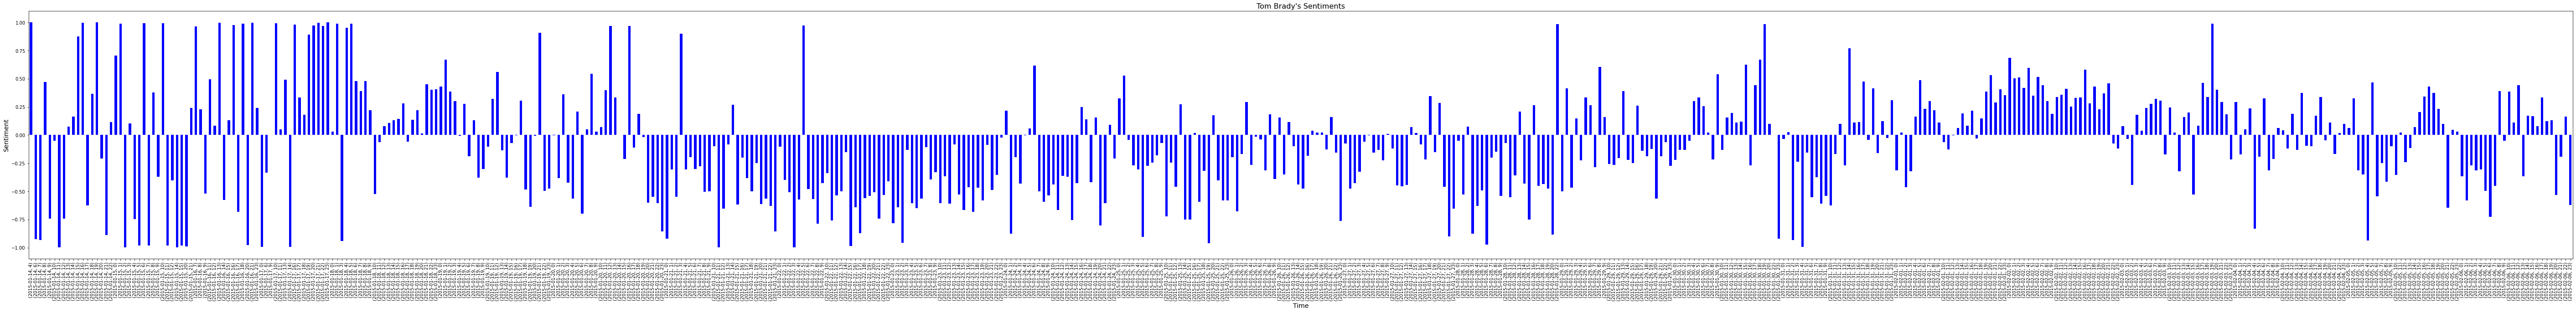

In [43]:
times = pd.to_datetime(df_brady.time)
grouped_brady = df_brady.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
sentimentSeries = pd.Series(data=list(grouped_brady), index=grouped_brady.keys())
sentimentSeries.plot.bar(figsize=(100,10), color='b', rot=90);
plt.xlabel("Time",fontsize=14)
plt.ylabel("Sentiment",fontsize=14)
plt.title("Tom Brady's Sentiments", fontsize = 16)

### Sentiment Analysis of Tom Brady during the game

In [48]:
# Sentiment Analysis during the game

Limdf= df_brady_gopatriots[(df_brady_gopatriots['time'] > '2015-02-01 15:00:00') & (df_brady_gopatriots['time'] < '2015-02-02 10:00:00')]
times = pd.to_datetime(Limdf.time)

Text(0.5, 1.0, "Tom Brady's Sentiments")

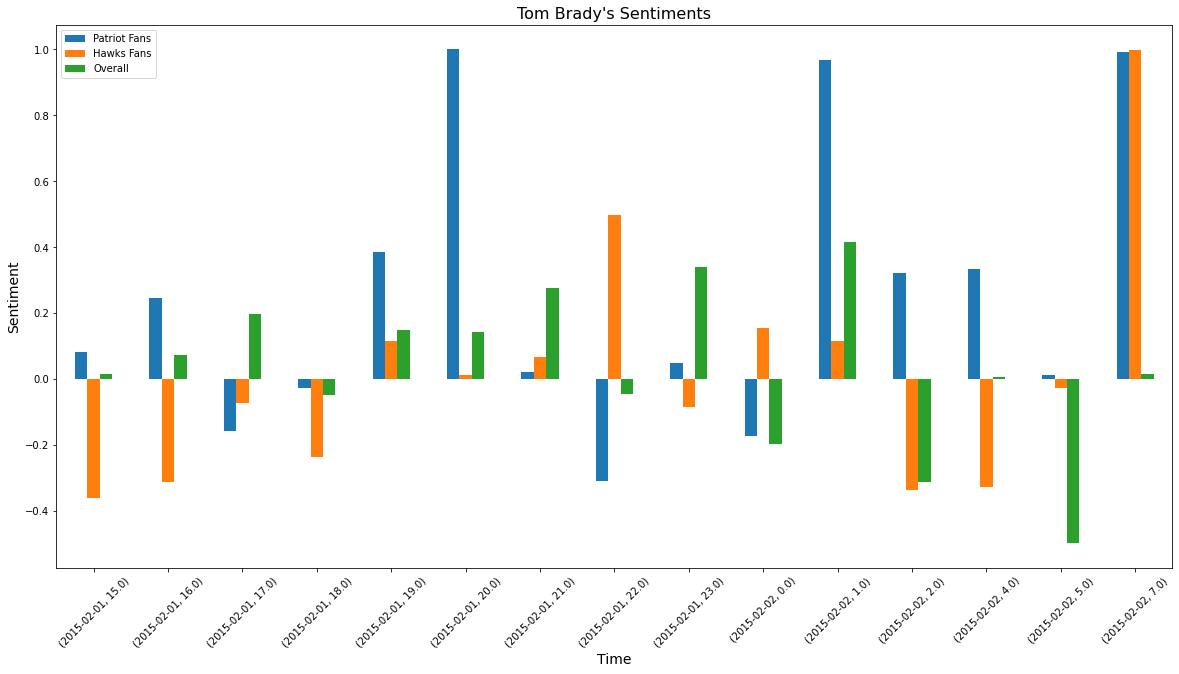

In [63]:
grouped_brady = df_brady.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_brady_gopatriots = df_brady_gopatriots.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_brady_gohawks = df_brady_gohawks.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
sentimentSeries = pd.DataFrame({'Patriot Fans':grouped_brady_gopatriots ,
                               'Hawks Fans': grouped_brady_gohawks,
                               'Overall': grouped_brady}, index=grouped_brady.keys())
sentimentSeries.plot.bar(figsize=(20,10), rot=45);
plt.xlabel("Time",fontsize=14)
plt.ylabel("Sentiment",fontsize=14)
plt.title("Tom Brady's Sentiments", fontsize = 16)

## Engagement Analysis of Tom Brady (During Match))

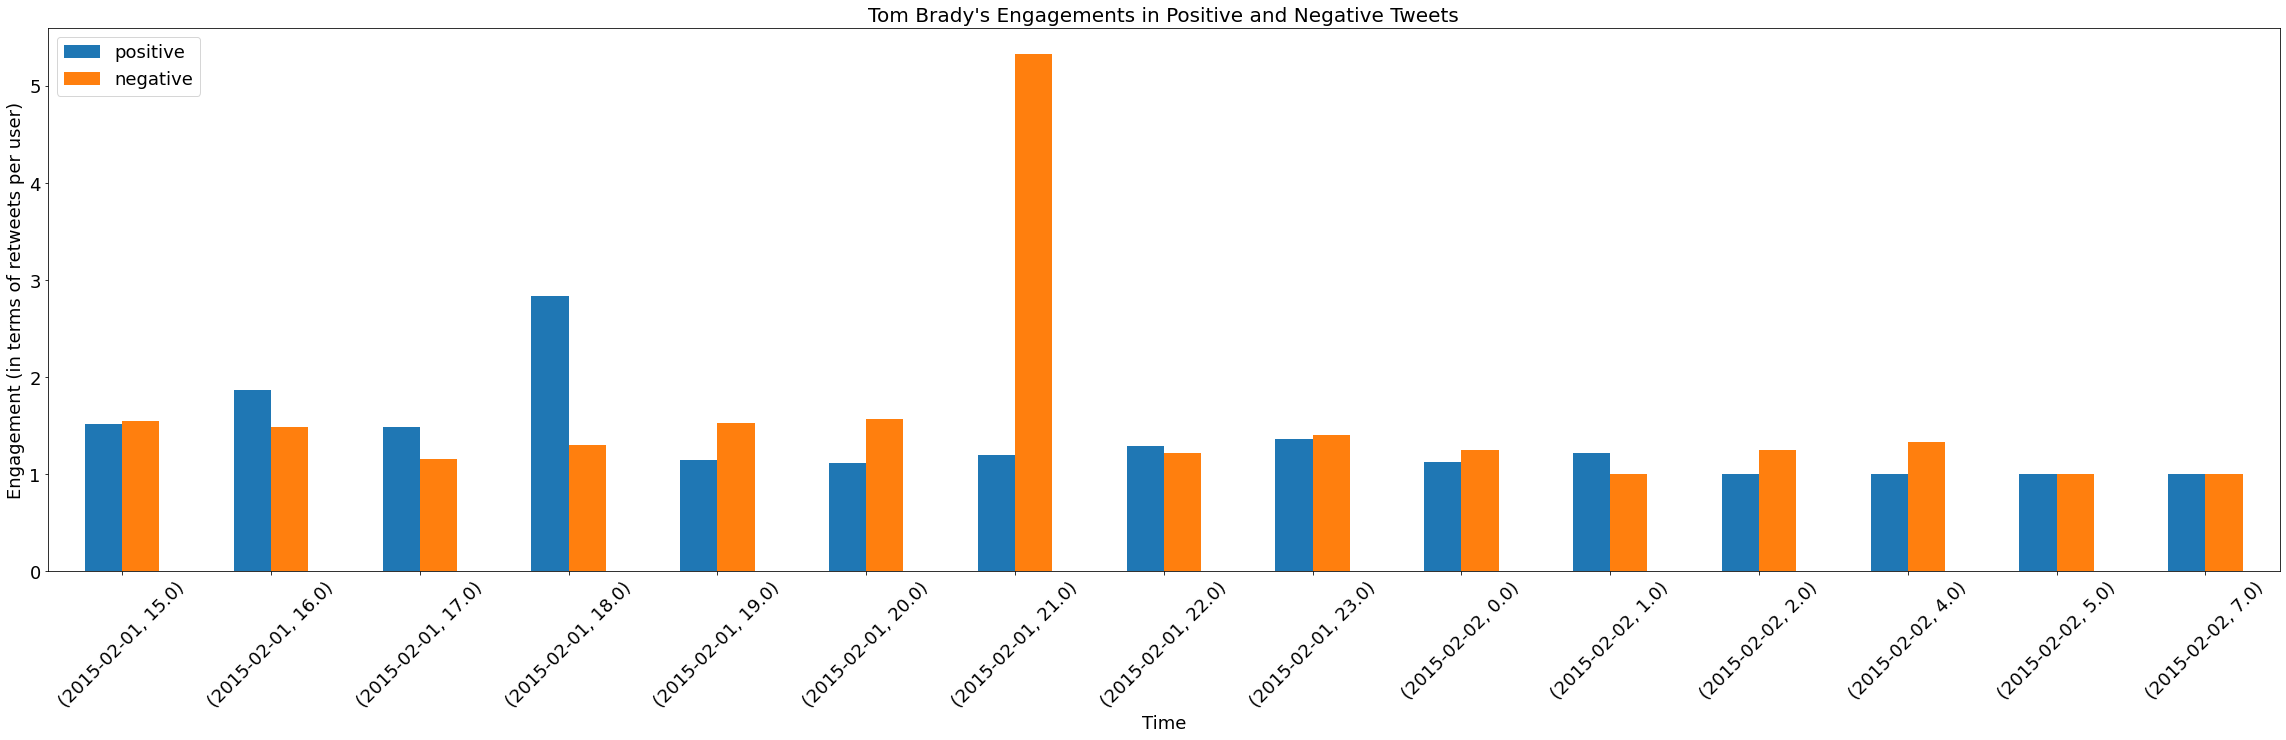

In [65]:
# Engagement during match

# Positive engagement
## plot for each hour

Limdf= df_brady_gopatriots[(df_brady_gopatriots['time'] > '2015-02-01 15:00:00') & (df_brady_gopatriots['time'] < '2015-02-02 10:00:00')]
times = pd.to_datetime(Limdf.time)
df_brady_positive = df_brady.loc[df_brady['sentiment_polarity'] == 1]
grouped_positive = df_brady_positive.groupby([times.dt.date, times.dt.hour]).retweet_count.mean()

# Negative engagement
## plot for each hour
df_brady_negative = df_brady.loc[df_brady['sentiment_polarity'] == -1]
grouped_negative = df_brady_negative.groupby([times.dt.date, times.dt.hour]).retweet_count.mean()
engagement = pd.DataFrame({'positive':grouped_positive ,
                   'negative': grouped_negative}, index=grouped_positive.keys())
engagement.plot.bar(figsize=(40,10), rot=45);
plt.xlabel("Time",fontsize=18)
plt.ylabel("Engagement (in terms of retweets per user)",fontsize=18)
plt.title("Tom Brady's Engagements in Positive and Negative Tweets", fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc= "upper left", fontsize=18)

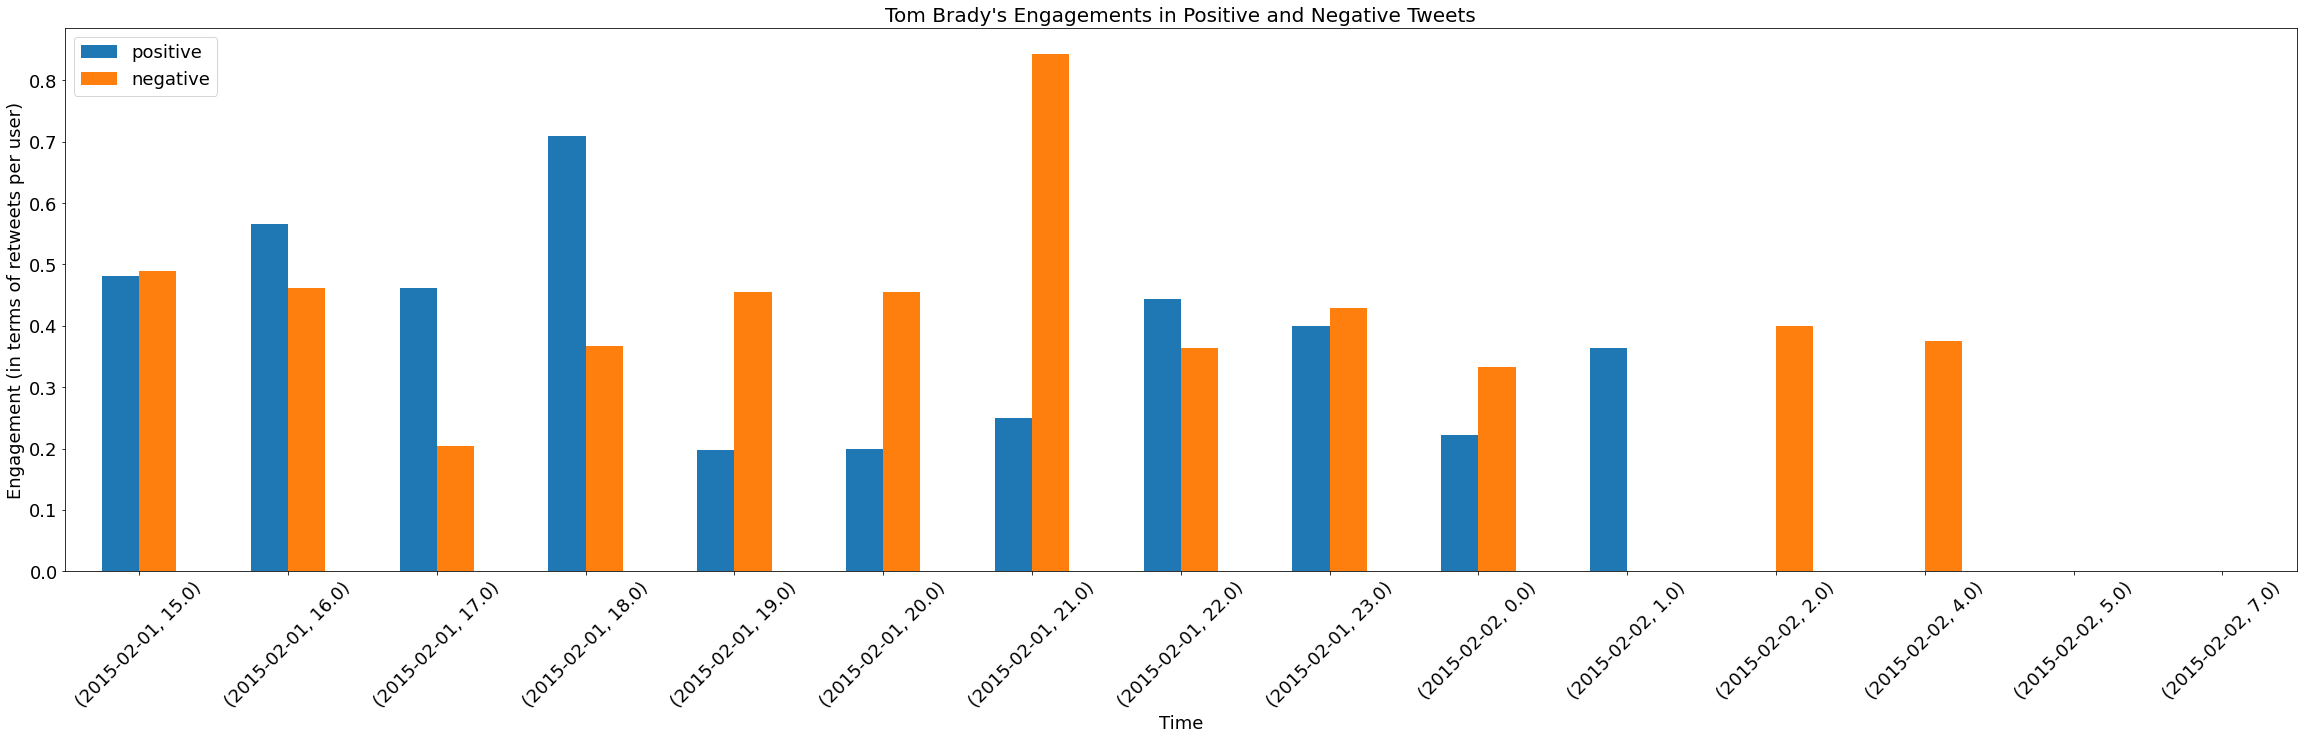

In [100]:
# Engagement during match

# Positive engagement
## plot for each hour

Limdf= df_brady_gopatriots[(df_brady_gopatriots['time'] > '2015-02-01 15:00:00') & (df_brady_gopatriots['time'] < '2015-02-02 10:00:00')]
times = pd.to_datetime(Limdf.time)
df_brady_positive = df_brady.loc[df_brady['sentiment_polarity'] == 1]
df_brady_positive_above = df_brady_positive.loc[df_brady_positive['retweet_count'] >=2 ]
grouped_positive = df_brady_positive.groupby([times.dt.date, times.dt.hour]).retweet_count.sum()
grouped_positive_above = df_brady_positive_above.groupby([times.dt.date, times.dt.hour]).retweet_count.sum()
grouped_positive = grouped_positive_above.div(grouped_positive, fill_value=0)

# Negative engagement
## plot for each hour
df_brady_negative = df_brady.loc[df_brady['sentiment_polarity'] == -1]
grouped_negative = df_brady_negative.groupby([times.dt.date, times.dt.hour]).retweet_count.sum()
df_brady_negative_above = df_brady_negative.loc[df_brady_negative['retweet_count'] >=2 ]
grouped_negative_above = df_brady_negative_above.groupby([times.dt.date, times.dt.hour]).retweet_count.sum()
grouped_negative = grouped_negative_above.div(grouped_negative, fill_value=0)

engagement = pd.DataFrame({'positive':grouped_positive ,
                   'negative': grouped_negative}, index=grouped_positive.keys())
engagement.plot.bar(figsize=(40,10), rot=45);
plt.xlabel("Time",fontsize=18)
plt.ylabel("Engagement (in terms of retweets per user)",fontsize=18)
plt.title("Tom Brady's Engagements in Positive and Negative Tweets", fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc= "upper left", fontsize=18)

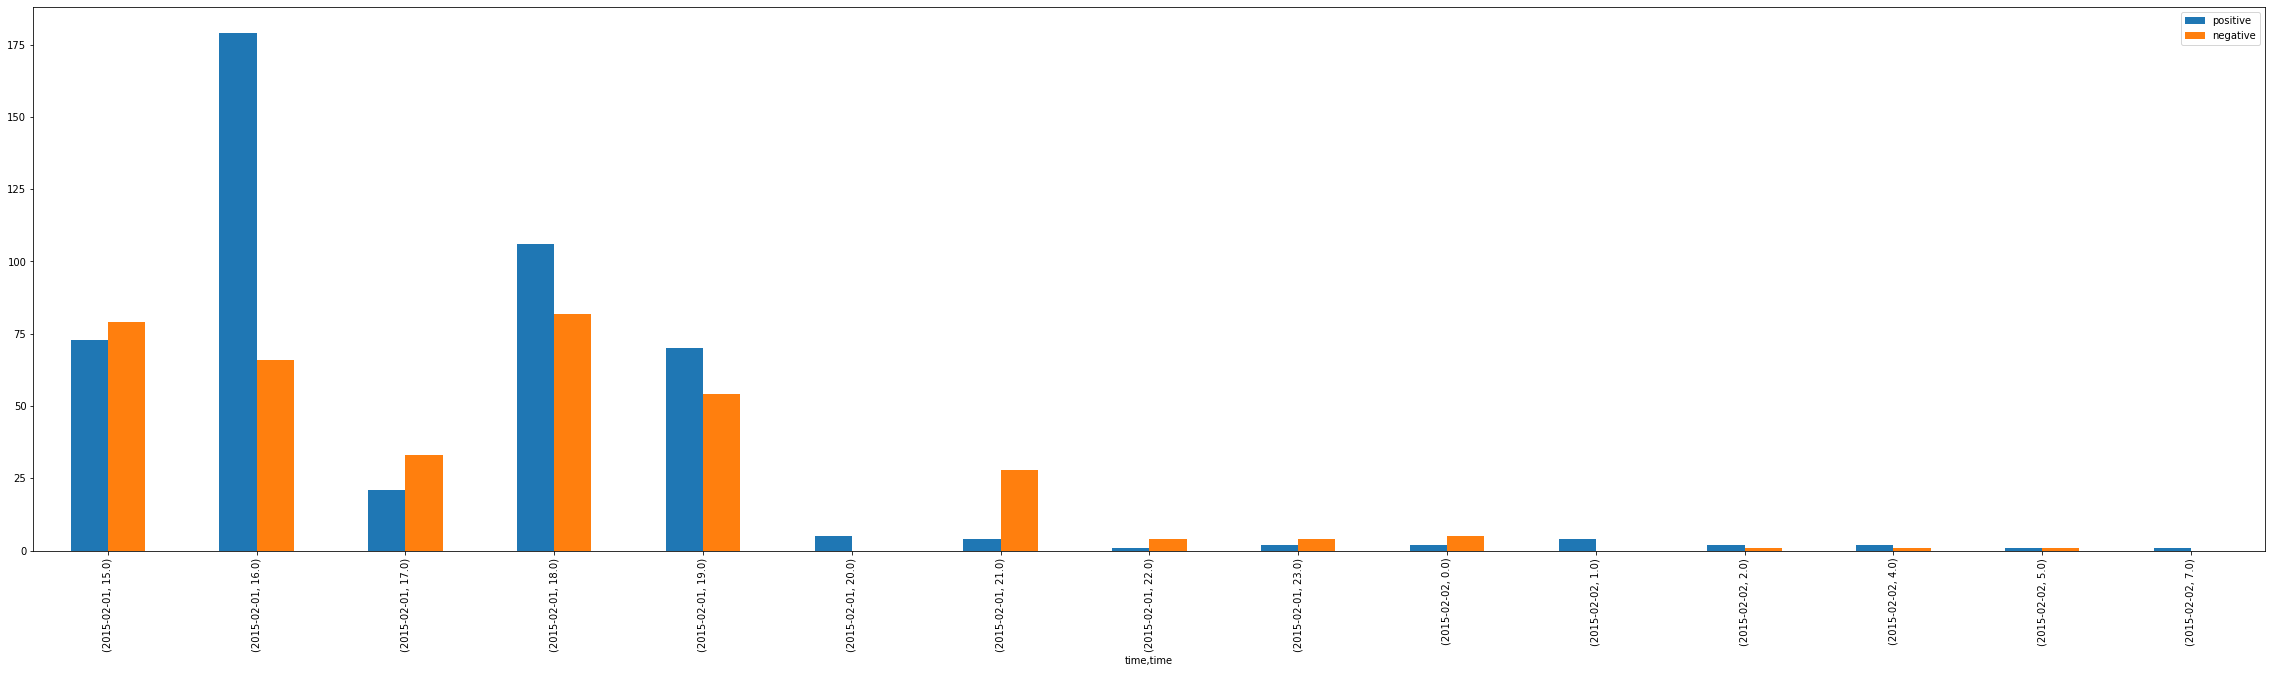

In [187]:
# Engagement during match

# Positive engagement
## plot for each hour

Limdf= df[(df['time'] > '2015-02-01 15:00:00') & (df['time'] < '2015-02-02 10:00:00')]
times = pd.to_datetime(Limdf.time)
df_positive = df.loc[df['sentiment_polarity'] == 1]
grouped_positive = df_positive.groupby([times.dt.date, times.dt.hour]).retweet_count.sum()

# Negative engagement
## plot for each hour
df_negative = df.loc[df['sentiment_polarity'] == -1]
grouped_negative = df_negative.groupby([times.dt.date, times.dt.hour]).retweet_count.sum()
engagementSeries = pd.DataFrame({'positive':grouped_positive ,
                   'negative': grouped_negative}, index=grouped_positive.keys())

engagementSeries.plot.bar(figsize=(40,10));

 ## Comparison of Sentiment Analysis of Tom Brady with Other Players

In [107]:
def get_player_all(player = 'Tom Brady'):
    player = player.lower().split()
    df_gopatriots = get_player('tweets_#gopatriots', player = player)
    df_gohawks = get_player('tweets_#gohawks', player = player)
    df_nfl = get_player_en('tweets_#nfl', player = player)
    df_superbowl = get_player_en('tweets_#superbowl', player = player)
    df = df_gopatriots.append(df_gohawks).append(df_nfl).append(df_superbowl)
    return df

In [108]:
## Pete Carrol 
df_carrol = get_player_all(player = 'Pete Carrol')

/home/shivam/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [110]:
## Malcolm Butler
df_butler = get_player_all(player = 'Malcolm Butler')

/home/shivam/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [111]:
# Russell Carrington Wilson
df_wilsen = get_player_all(player = 'Russell Carrington Wilson')

/home/shivam/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [112]:
# Richard Kevin Sherman
df_shermen = get_player_all(player = 'Richard Kevin Sherman')

/home/shivam/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [113]:
# Robert James Gronkowski
df_gronkowski = get_player_all(player = 'Robert James Gronkowski')

In [114]:
# Sentiment Analysis during the game

Limdf= df_brady_gopatriots[(df_brady_gopatriots['time'] > '2015-02-01 15:00:00') & (df_brady_gopatriots['time'] < '2015-02-02 10:00:00')]
times = pd.to_datetime(Limdf.time)


Text(0.5, 1.0, 'Sentiments across different players')

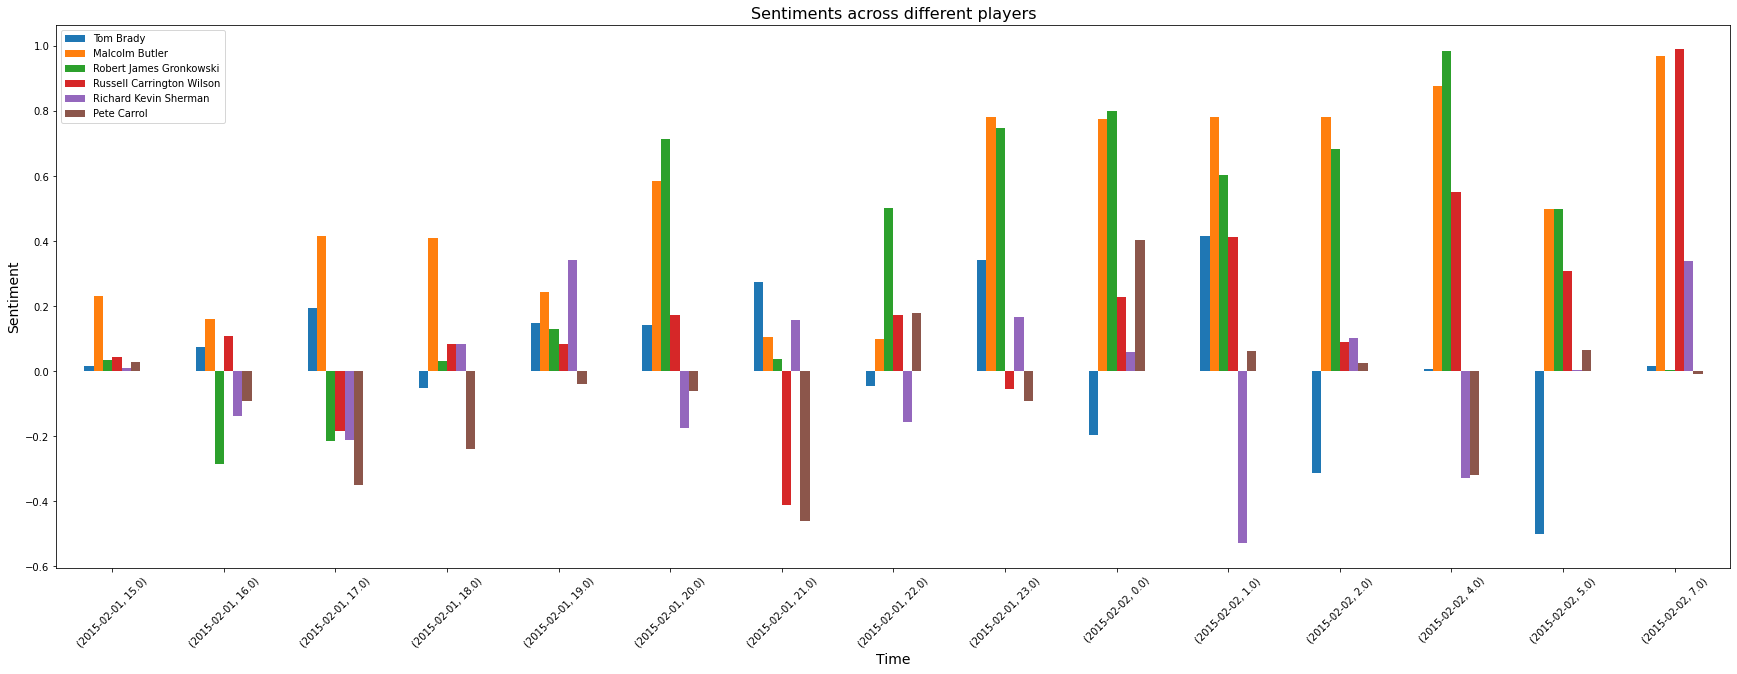

In [121]:
grouped_brady = df_brady.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_carrol = df_carrol.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_butler = df_butler.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_wilsen = df_wilsen.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_shermen = df_shermen.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()
grouped_gronkowski = df_gronkowski.groupby([times.dt.date, times.dt.hour]).sentiment_score.mean()

sentimentSeries = pd.DataFrame({'Tom Brady':grouped_brady,
                                'Malcolm Butler': grouped_butler,
                                'Robert James Gronkowski': grouped_gronkowski,
                                'Russell Carrington Wilson': grouped_wilsen, 
                                'Richard Kevin Sherman': grouped_shermen,
                                'Pete Carrol': grouped_carrol
                               }, index=grouped_brady.keys())
sentimentSeries.plot.bar(figsize=(30,10), rot=45);
plt.xlabel("Time",fontsize=14)
plt.ylabel("Sentiment",fontsize=14)
plt.title("Sentiments across different players", fontsize = 16)